Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with SC.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with SC.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
np.__version__

'1.26.4'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [6]:
# Define parameter space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

In [7]:
# Set up and run a campaign
def run_campaign(sc_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_sc."
    my_campaign = uq.Campaign(name='Ishigami_sc.')


    # Create an encoder and decoder for SC test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.SCSampler(vary=define_vary(), polynomial_order=sc_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate(progress_bar=True)

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, sc_order, my_campaign.get_active_sampler().count

In [8]:
# Calculate the stochastic collocation expansion for a range of orders

R = {}
for sc_order in range(1, 21):
    R[sc_order] = {}
    (R[sc_order]['results_df'], 
     R[sc_order]['results'], 
     R[sc_order]['times'], 
     R[sc_order]['order'], 
     R[sc_order]['number_of_samples']) = run_campaign(sc_order=sc_order, use_files=False)

Time for phase 1 = 0.056
Number of samples = 8
Time for phase 2 = 0.082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1007.10it/s]

Time for phase 3 = 0.018
Time for phase 4 = 0.006
Time for phase 5 = 0.015
Time for phase 6 = 0.002
Time for phase 1 = 0.017


Number of samples = 27
Time for phase 2 = 0.130


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1096.23it/s]

Time for phase 3 = 0.035
Time for phase 4 = 0.009
Time for phase 5 = 0.029
Time for phase 6 = 0.001
Time for phase 1 = 0.015


Number of samples = 64
Time for phase 2 = 0.200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1462.86it/s]

Time for phase 3 = 0.056
Time for phase 4 = 0.005
Time for phase 5 = 0.055
Time for phase 6 = 0.001
Time for phase 1 = 0.015


Number of samples = 125
Time for phase 2 = 0.279


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 1623.03it/s]

Time for phase 3 = 0.095
Time for phase 4 = 0.006


Time for phase 5 = 0.111
Time for phase 6 = 0.001
Time for phase 1 = 0.020
Number of samples = 216
Time for phase 2 = 0.390


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 1694.92it/s]

Time for phase 3 = 0.147
Time for phase 4 = 0.010


Time for phase 5 = 0.187
Time for phase 6 = 0.001
Time for phase 1 = 0.016
Number of samples = 343
Time for phase 2 = 0.505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 1680.84it/s]


Time for phase 3 = 0.233
Time for phase 4 = 0.012
Time for phase 5 = 0.326
Time for phase 6 = 0.002
Time for phase 1 = 0.018
Number of samples = 512
Time for phase 2 = 0.664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1724.99it/s]


Time for phase 3 = 0.331
Time for phase 4 = 0.015
Time for phase 5 = 0.451
Time for phase 6 = 0.002
Time for phase 1 = 0.013
Number of samples = 729
Time for phase 2 = 0.802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 1695.30it/s]


Time for phase 3 = 0.599
Time for phase 4 = 0.019
Time for phase 5 = 0.670
Time for phase 6 = 0.003
Time for phase 1 = 0.013
Number of samples = 1000
Time for phase 2 = 1.011


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1789.15it/s]


Time for phase 3 = 0.616
Time for phase 4 = 0.028
Time for phase 5 = 0.934
Time for phase 6 = 0.003
Time for phase 1 = 0.013
Number of samples = 1331
Time for phase 2 = 1.216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1331/1331 [00:00<00:00, 1744.96it/s]


Time for phase 3 = 0.957
Time for phase 4 = 0.035
Time for phase 5 = 1.303
Time for phase 6 = 0.005
Time for phase 1 = 0.013
Number of samples = 1728
Time for phase 2 = 1.492


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1728/1728 [00:00<00:00, 1780.90it/s]


Time for phase 3 = 1.065
Time for phase 4 = 0.165
Time for phase 5 = 1.793
Time for phase 6 = 0.006
Time for phase 1 = 0.013
Number of samples = 2197
Time for phase 2 = 1.907


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2197/2197 [00:01<00:00, 1750.37it/s]


Time for phase 3 = 1.372
Time for phase 4 = 0.170
Time for phase 5 = 2.562
Time for phase 6 = 0.006
Time for phase 1 = 0.013
Number of samples = 2744
Time for phase 2 = 2.153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2744/2744 [00:01<00:00, 1761.55it/s]


Time for phase 3 = 1.815
Time for phase 4 = 0.066
Time for phase 5 = 3.368
Time for phase 6 = 0.008
Time for phase 1 = 0.013
Number of samples = 3375
Time for phase 2 = 2.652


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:01<00:00, 1697.78it/s]


Time for phase 3 = 2.285
Time for phase 4 = 0.084
Time for phase 5 = 5.282
Time for phase 6 = 0.018
Time for phase 1 = 0.017
Number of samples = 4096
Time for phase 2 = 4.139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:03<00:00, 1346.26it/s]


Time for phase 3 = 3.383
Time for phase 4 = 0.130
Time for phase 5 = 8.839
Time for phase 6 = 0.036
Time for phase 1 = 0.038
Number of samples = 4913
Time for phase 2 = 12.450


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4913/4913 [00:10<00:00, 483.04it/s]


Time for phase 3 = 10.995
Time for phase 4 = 0.246
Time for phase 5 = 7.682
Time for phase 6 = 0.014
Time for phase 1 = 0.015
Number of samples = 5832
Time for phase 2 = 4.127


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5832/5832 [00:03<00:00, 1722.46it/s]


Time for phase 3 = 3.806
Time for phase 4 = 0.251
Time for phase 5 = 11.178
Time for phase 6 = 0.030
Time for phase 1 = 0.029
Number of samples = 6859
Time for phase 2 = 11.364


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6859/6859 [00:06<00:00, 1097.56it/s]


Time for phase 3 = 7.134
Time for phase 4 = 0.231
Time for phase 5 = 17.712
Time for phase 6 = 0.024
Time for phase 1 = 0.017
Number of samples = 8000
Time for phase 2 = 7.719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1100.45it/s]


Time for phase 3 = 7.973
Time for phase 4 = 0.280
Time for phase 5 = 23.564
Time for phase 6 = 0.034
Time for phase 1 = 0.021
Number of samples = 9261
Time for phase 2 = 9.076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9261/9261 [00:09<00:00, 968.08it/s]


Time for phase 3 = 10.485
Time for phase 4 = 0.491
Time for phase 5 = 29.883
Time for phase 6 = 0.041


In [9]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [10]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.179226,0.056367,0.081730,0.018163,0.005862,0.015274,0.001647
2,0.221083,0.016921,0.130337,0.035211,0.008635,0.029249,0.000585
3,0.330997,0.014890,0.199951,0.055545,0.004510,0.055324,0.000649
4,0.507441,0.014533,0.279276,0.095040,0.005932,0.111420,0.001055
5,0.754666,0.019545,0.389641,0.146993,0.010212,0.186779,0.001244
6,1.095640,0.016500,0.505486,0.233469,0.012386,0.325934,0.001648
7,1.481268,0.018189,0.663666,0.331013,0.015351,0.450978,0.001902
8,2.106097,0.013244,0.801629,0.598971,0.018567,0.670377,0.003102
9,2.605201,0.013377,1.010512,0.615705,0.028224,0.933823,0.003345
10,3.527976,0.012983,1.215686,0.956930,0.034585,1.302955,0.004659


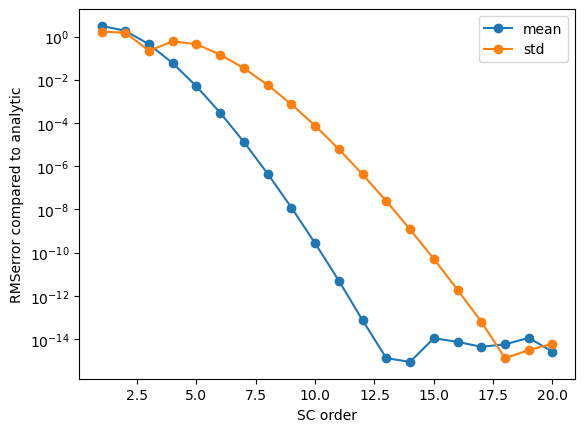

In [11]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('SC order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

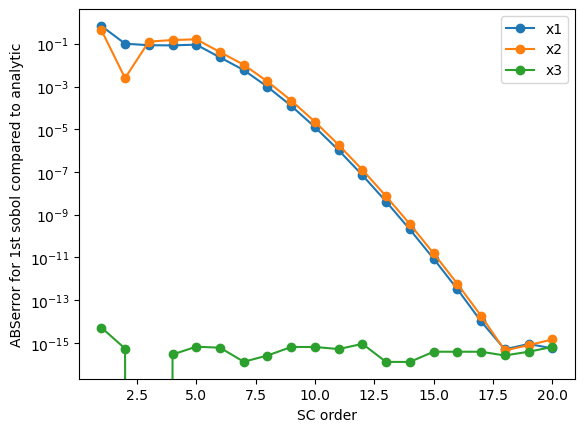

In [12]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('SC order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

In [13]:
# prepare the test data
test_campaign = uq.Campaign(name='Ishigami.')        
test_campaign.add_app(name="Ishigami", params=define_params(), 
                      actions=uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model)))
test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))
test_campaign.execute(nsamples=1000, sequential=True).collate(progress_bar=True)
test_df = test_campaign.get_collation_result()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1150.31it/s]


In [14]:
# calculate the SC surrogates
if __name__ == '__main__':

    test_points = test_df[test_campaign.get_active_sampler().vary.get_keys()]
    test_results = np.squeeze(test_df['Ishigami'].values)
    test_predictions = {}
    for i in list(R.keys()):
        test_predictions[i] = np.squeeze(np.array(R[i]['results'].surrogate()(test_points)['Ishigami']))

/tmp/ipykernel_104837/2228134460.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)


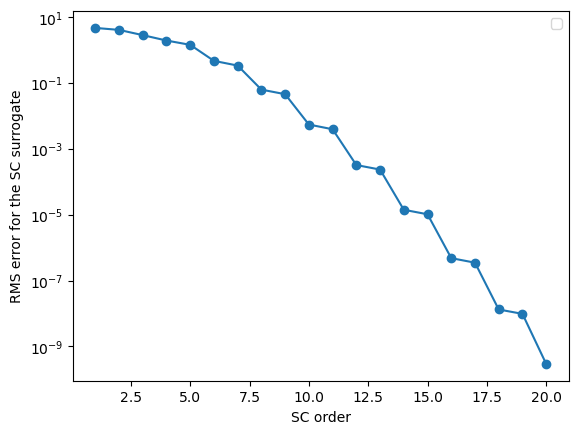

In [15]:
# plot the convergence of the surrogate
if __name__ == '__main__':
    _o = []
    _RMS = []
    for r in R.values():
        _RMS.append((np.sqrt((((test_predictions[r['order']] - test_results))**2).mean())))
        _o.append(r['order'])

    plt.figure()
    plt.semilogy(_o, _RMS, 'o-')
    plt.xlabel('SC order')
    plt.ylabel('RMS error for the SC surrogate')
    plt.legend(loc=0)
    plt.savefig('Convergence_SC_surrogate.png')
    plt.savefig('Convergence_SC_surrogate.pdf')